# Sentiment Analysis on COVID-related Tweets

Group Name: Neem

Group member: Yuanzhi Xu, Chia-wei Lin, Wen Xie

## Table of Contents
1. import dependencies
2. read data
5. preprocess text
    - decode emoji
    - decode HTML
    - remove mention
    - remove URL
    - remove punctuation
    - correct repeatted letters
    - lemmatize and stemming
    - remove stop words
6. analyze data
    - class distribution
    - wordcloud
7. train-test split
8. word vectorization
    - CountVectorizer (using train data)
    - TfidfVectorizer (using train data)
    - GloVe embedding (pretrained)
9. create models
    - BernoulliNB Model
    - LinearSVC Model
    - Logistic Regression Model
    - Random Forest Model
    - Xgboost Model
10. evaluate models

## IMPORT DEPENDENCIES

In [1]:
# # install and update dependencies
# !pip install numpy --upgrade
# !pip install pandas --upgrade
# !pip install emoji --upgrade
# !pip install tqdm --upgrade
# !pip install nltk --upgrade
# !pip install xgboost --upgrade

In [2]:
# DataFrame
import pandas as pd
import numpy as np
import json

# for preprocessing
import emoji
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Utility
import os
from collections import Counter
import pickle
import codecs
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

# For visualizing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# xgboost
import xgboost as xgb

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashleyxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ashleyxu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
TRAIN_SIZE = 0.8
EMBEDDING_DIM = 200

## READ DATA

In [4]:
DATASET_CITATION = """
@ONLINE {Sentiment140,
    author = "Go, Alec and Bhayani, Richa and Huang, Lei",
    title  = "Twitter Sentiment Classification using Distant Supervision",
    year   = "2009",
    url    = "http://help.sentiment140.com/home"
}
"""
DATASET_DESCRIPTION = """
Sentiment140 allows you to discover the sentiment of a brand, product, or topic on Twitter.
The data is a CSV with emoticons removed. Data file format has 6 fields:
0. the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. the id of the tweet (2087)
2. the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3. the query (lyx). If there is no query, then this value is NO_QUERY.
4. the user that tweeted (robotickilldozr)
5. the text of the tweet (Lyx is cool)
For more information, refer to the paper
Twitter Sentiment Classification with Distant Supervision at
https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf
"""
DATASET_DOWNLOAD_URL = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
DATASET_HOMEPAGE_URL = "http://help.sentiment140.com/home"
DATASET_FILE = "training.1600000.processed.noemoticon.csv"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
DATASET_LABEL = {0:"negative", 2:"neutral", 4:"positive"}

In [5]:
# # download dataset
# ! wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
# ! unzip trainingandtestdata.zip

In [6]:
# read dataset
df = pd.read_csv(DATASET_FILE, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## PREPROCESS TEXT

In [7]:
def decode_emoji(text):
    output = []
    for t in emoji.demojize(text).split():
        output.extend(t.split("_"))
    return ' '.join(output)

def decode_HTML(text):
    return BeautifulSoup(text, 'lxml').get_text()

def remove_mention(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)
    
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def correct_repeatted_letters(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def to_lowercase(text):
    return ' '.join([w.lower() for w in text.split()])
 
def lemmatize_stemming(text):
    return ' '.join([stemmer.stem(lemmatizer.lemmatize(w, pos='v'))
                     for w in text.split()])

def remove_stop_words(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

In [8]:
def preprocess(text):
    text = decode_emoji(text)
    text = decode_HTML(text)
    text = remove_mention(text)
    text = remove_URL(text)
    text = remove_punctuation(text)
    text = correct_repeatted_letters(text)
    text = to_lowercase(text)       
    text = lemmatize_stemming(text)
    text = remove_stop_words(text)
    return text

In [9]:
# # sample smaller dataset for testing purpose
# df = df.sample(n=1000, random_state=42)

In [10]:
# preprocess text
# import nltk
# nltk.download('wordnet')

tqdm_notebook.pandas()
df['text_cleaned'] = df['text'].progress_apply(lambda x: preprocess(x))
df['sentiment'] = df['target'].apply(lambda x: DATASET_LABEL[x])
df.head(5)

  0%|          | 0/1600000 [00:00<?, ?it/s]

,target,ids,date,flag,user,text,text_cleaned,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda get david carr third day,negative
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...,negative
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save 50 rest go bound,negative
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,negative
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behav mad whi becaus see,negative


## ANALYZE DATA

In [11]:
# analyse class distribution
val_count = df.sentiment.value_counts()
val_count

negative    800000
positive    800000
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Sentiment class Distribution')

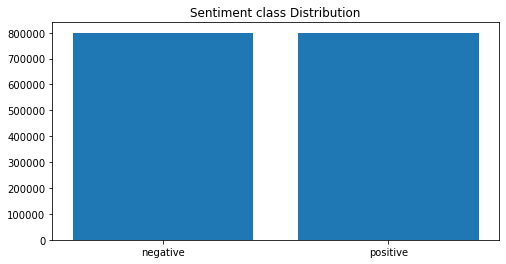

In [12]:
# visuallize class distribution
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment class Distribution")

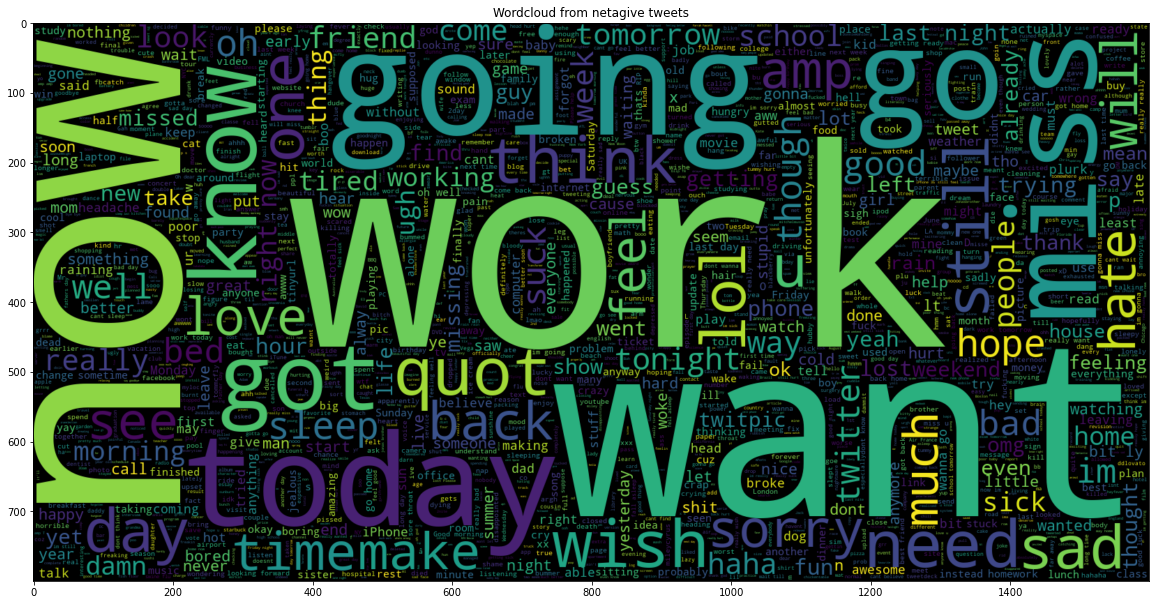

In [13]:
# visuallize negative tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == DATASET_LABEL[0]].text))
plt.title("Wordcloud from netagive tweets")
plt.imshow(wc , interpolation = 'bilinear')

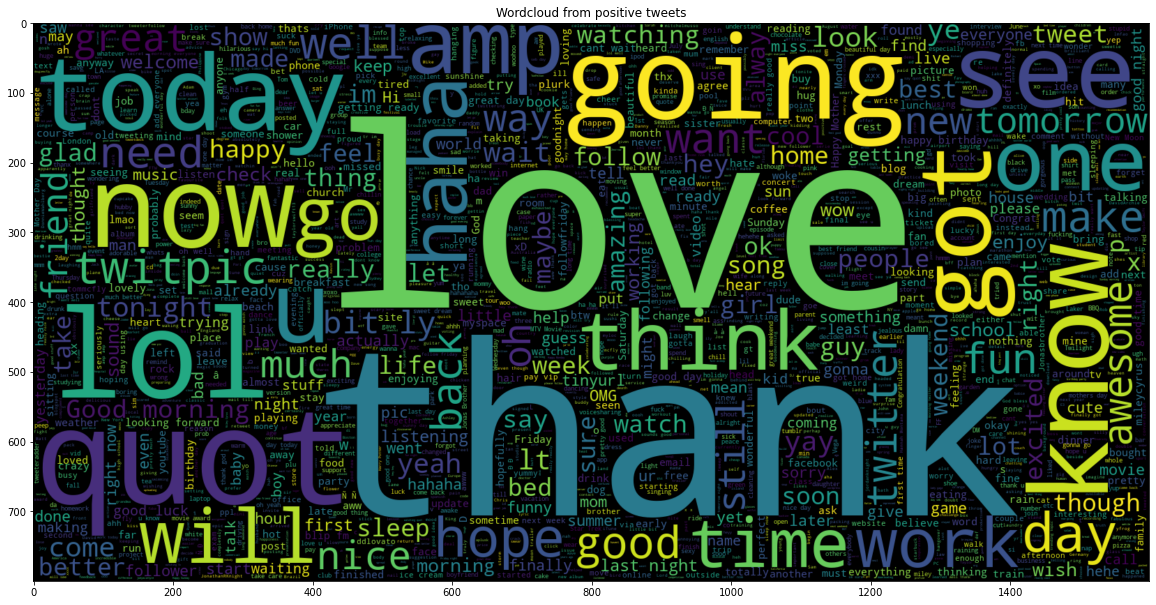

In [14]:
# visuallize positive tweets
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == DATASET_LABEL[4]].text))
plt.title("Wordcloud from positive tweets")
plt.imshow(wc , interpolation = 'bilinear')

## TRAIN-TEST SPLIT

In [15]:
# train test split
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [16]:
y_train = np.array(df_train.sentiment)
y_test = np.array(df_test.sentiment)

In [17]:
# helper function for model evalutation
models = {} 
def model_Evaluate(name, model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    # Print accuracy on Test dataset
    acc_test = accuracy_score(y_test, y_pred)
    models[name] = {"model": model, "acc_test": acc_test}
    print('==> {}: acc = {:.4%}'.format(name, acc_test))

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## WORD VECTORIZATION

==> SVM with unigram: acc = 76.2938%
              precision    recall  f1-score   support

    negative       0.78      0.74      0.76    159494
    positive       0.75      0.79      0.77    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



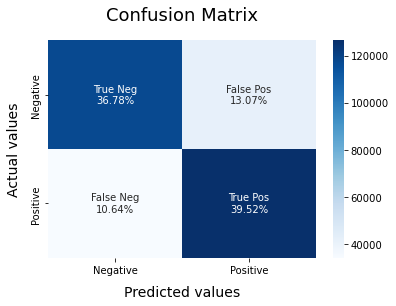

In [18]:
# test SVM model with unigram vectorizer
vectorizer = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 1))
X_train = vectorizer.fit_transform(df_train.text_cleaned)
X_test = vectorizer.transform(df_test.text_cleaned)

SVCmodel = LinearSVC(dual=False)
SVCmodel.fit(X_train, y_train)
model_Evaluate("SVM with unigram", SVCmodel)

In [19]:
# test SVM model with pretrained gloVe embedding
# Download pretrained GloVe embedding
# ! wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
# ! unzip glove.twitter.27B.zip

1374558    ya like palm pre touchston charger readynow ye...
1389115                felt earthquak afternoon seem epicent
1137831                               ruffl shirt like likey
790714     pretti bad night crappi morn fml onli buttfac ...
1117911                                      yeah clear view
                                 ...                        
259178                      song middl chang want bear arghh
1414414                                            good luck
131932                                   rather averag 32370
671155     pickin waitin 2 hurri ode miss dem tabl talk 2...
121958                  home studi math woot im go fail shit
Name: text_cleaned, Length: 1280000, dtype: object
  (0, 38825)	0.3333512042434949
  (0, 179490)	0.28967748301956414
  (0, 386369)	0.19596102785547023
  (0, 492804)	0.285064753198394
  (0, 319313)	0.23355250577073405
  (0, 253952)	0.31971069929037654
  (0, 486376)	0.2653920866635271
  (0, 335372)	0.3028153976325202
  (0, 344205

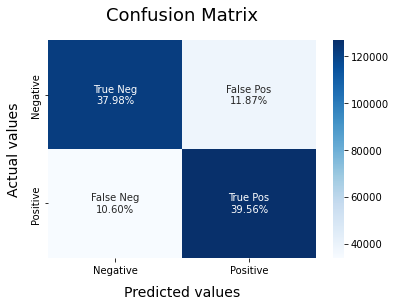

In [20]:
# test SVM model with tf-idf vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_train = vectorizer.fit_transform(df_train.text_cleaned)
X_test = vectorizer.transform(df_test.text_cleaned)

SVCmodel = LinearSVC(dual=False)
SVCmodel.fit(X_train, y_train)
model_Evaluate("SVM with tf-idf", SVCmodel)

In [21]:
print('loading word embeddings from GloVe...')

embeddings_index = {}
f = codecs.open('glove.twitter.27B.200d.txt', encoding='utf-8')

for line in tqdm(f, total=1193515):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings from GloVe...


100%|████████████████████████████████████████████████████████████| 1193515/1193515 [01:00<00:00, 19728.81it/s]

found 1193514 word vectors


In [22]:
# create word_index
counter = Counter(word for text in df_train.text_cleaned for word in text.split())
words_list = sorted(counter.items(), key=lambda x:x[1], reverse=True)
word_index = {word[0]: i+1 for i, word in enumerate(words_list)}
print("dictionary size: ", len(word_index))

# generate embedding matrix
vocab_size = len(embeddings_index)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('matrix shape = ', embedding_matrix.shape)

dictionary size:  196503
matrix shape =  (1193514, 200)


In [23]:
def sentence_embedding_padding(text, dictionary, dim):
    sen_embedding = [0] * dim
    w_count = 0
    for w in text.split():
        if w in dictionary:
            w_count += 1
            w_embedding = dictionary[w]
            for i in range(dim):
                sen_embedding[i] += w_embedding[i]
    return np.array(sen_embedding)

In [24]:
# test SVM model with pretrained GloVe embedding
tqdm_notebook.pandas()
X_train = df_train['text_cleaned'].progress_apply(lambda x: sentence_embedding_padding(x, embeddings_index, EMBEDDING_DIM))
X_test = df_test['text_cleaned'].progress_apply(lambda x: sentence_embedding_padding(x, embeddings_index, EMBEDDING_DIM))

  0%|          | 0/1280000 [00:00<?, ?it/s]

  0%|          | 0/320000 [00:00<?, ?it/s]

In [25]:
X_train = list(X_train)
X_test = list(X_test)

==> SVM with GloVe: acc = 72.7987%
              precision    recall  f1-score   support

    negative       0.74      0.70      0.72    159494
    positive       0.72      0.75      0.73    160506

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



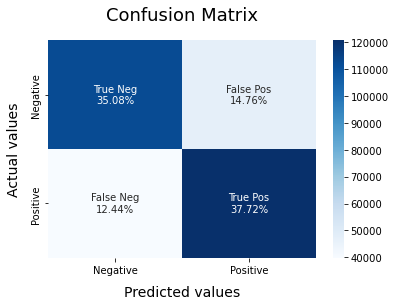

In [26]:
SVCmodel = LinearSVC(dual=False)
SVCmodel.fit(X_train, y_train)
model_Evaluate("SVM with GloVe", SVCmodel)

## CREATE MODELS

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_train = vectorizer.fit_transform(df_train.text_cleaned)
X_test = vectorizer.transform(df_test.text_cleaned)

In [28]:
X_train = preprocessing.scale(X_train, with_mean=False)
X_test = preprocessing.scale(X_test, with_mean=False)

==> BernoulliNB: acc = 77.6366%
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77    159494
    positive       0.76      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



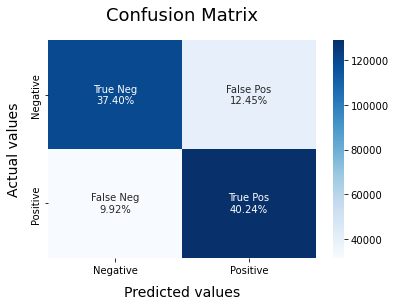

In [29]:
# BernoulliNB Model
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate("BernoulliNB", BNBmodel)

/Users/ashleyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


==> LinearSVC: acc = 67.7741%
              precision    recall  f1-score   support

    negative       0.68      0.67      0.68    159494
    positive       0.68      0.68      0.68    160506

    accuracy                           0.68    320000
   macro avg       0.68      0.68      0.68    320000
weighted avg       0.68      0.68      0.68    320000



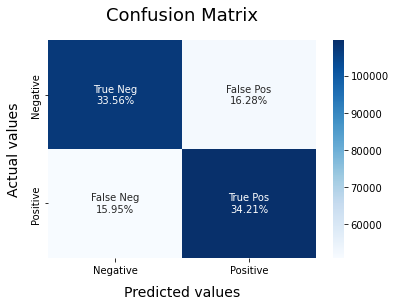

In [30]:
# LinearSVC Model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate("LinearSVC", SVCmodel)

/Users/ashleyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


==> Logistic Regression: acc = 70.1428%
              precision    recall  f1-score   support

    negative       0.70      0.69      0.70    159494
    positive       0.70      0.71      0.71    160506

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000



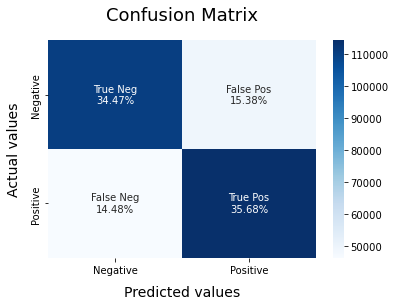

In [31]:
# Logistic Regression Model
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate("Logistic Regression", LRmodel)

In [33]:
# Random Forest Model
RFModel = RandomForestClassifier(random_state=42)
RFModel.fit(X_train, y_train)
model_Evaluate("Random Forest" ,RFModel)

KeyboardInterrupt: 

In [ ]:
# Xgboost Model
# XGBmodel = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# XGBmodel.fit(X_train, y_train)
# model_Evaluate("Xgboost", XGBmodel)

In [34]:
models_in_order = sorted(models.items(), key=lambda x: x[1]['acc_test'], reverse=True)

for m in models_in_order:
    print(m)

('BernoulliNB', {'model': BernoulliNB(alpha=2), 'acc_test': 0.776365625})
('SVM with tf-idf', {'model': LinearSVC(dual=False), 'acc_test': 0.775328125})
('SVM with unigram', {'model': LinearSVC(dual=False), 'acc_test': 0.7629375})
('SVM with GloVe', {'model': LinearSVC(dual=False), 'acc_test': 0.7279875})
('Logistic Regression', {'model': LogisticRegression(C=2, max_iter=1000, n_jobs=-1), 'acc_test': 0.701428125})
('LinearSVC', {'model': LinearSVC(), 'acc_test': 0.677740625})


## Apply Real-world Tweet Data

Note: How to fit trained model to real-word tweets:

0. process jsonl files and convert them to csv and then to dataframe
1. cleaned_text = preprocess(text)
2. vectorized_text = vectorizer.transform(cleaned_text)
3. prediction = best_model.predict(vectorized_text)

In [153]:
## zip files
OUT_DIR = "../COVID-19-TweetIDs/"
JSON_DIR = OUT_DIR + "2022-02/"

# Fridays in Ferburary 2022
files= ["coronavirus-tweet-id-2022-02-04-07.jsonl",
        "coronavirus-tweet-id-2022-02-18-02.jsonl",
        "coronavirus-tweet-id-2022-02-11-02.jsonl",
        "coronavirus-tweet-id-2022-02-25-08.jsonl"]

In [155]:
from datetime import datetime 
def get_date(string):
    return datetime.strptime(string, "%Y-%m-%dT%H:%M:%S.%fZ")

In [156]:
def process(line):
    # from json to single line df
    df_inter = pd.DataFrame([line])
    df_inter.columns = ['json_element']
    df_inter['json_element'].apply(json.loads)
    df_inter = pd.json_normalize(df_inter['json_element'].apply(json.loads))
    # extract needed columns
    df_needed = df_inter[['created_at', 'id', 'text', 'lang']]
    # format date
    df_needed["date"] = df_needed["created_at"].apply(get_date)
    df_needed['date'] = df.apply(lambda row: get_date(row['created_at']), axis =1)
    
    df_needed.drop(["created_at"], axis=1)
    
    return df_needed

In [200]:
import tqdm
df = pd.DataFrame()

In [201]:
# jsonl -> csv -> dataframe
for file in files:
    with tqdm.tqdm(total=os.path.getsize(JSON_DIR + file)) as pbar:
        with open(JSON_DIR + file, 'r') as reader:
            for line in reader:
                pbar.update(len(line))
                df_line = process(line.strip("\n"))
                if df_line["lang"][0] == "en":
                    frames = [df, df_line]
                    df = pd.concat(frames)

100%|█████████████████████| 434427423/434427423 [05:41<00:00, 1273840.36it/s]


In [202]:
df.head(5)

,created_at,id,text,lang
0,2022-02-04T06:59:55.000Z,1489493905406296064,"RT @DINESHK98891550: In the whole world, 100% ...",en
0,2022-02-04T06:59:55.000Z,1489493905426956288,RT @nicksey: Lol we're in trouble when he star...,en
0,2022-02-04T06:59:55.000Z,1489493905410121733,Vaccine manufacturers cannot be sued … what an...,en
0,2022-02-04T06:59:55.000Z,1489493905619832834,"We just gave China 1.2 Billion, yes Billion, f...",en
0,2022-02-04T06:59:55.000Z,1489493905951186947,RT @nicksey: Lol we're in trouble when he star...,en


In [203]:
# Preprocess and clean text
df['text_cleaned'] = df['text'].progress_apply(lambda x: preprocess(x))

  0%|          | 0/174660 [00:00<?, ?it/s]

In [204]:
df = df.reset_index()
static_df = pd.DataFrame()
static_df = df.copy()
df.head(5)

,index,created_at,id,text,lang,text_cleaned
0,0,2022-02-04T06:59:55.000Z,1489493905406296064,"RT @DINESHK98891550: In the whole world, 100% ...",en,rt whole world 100 cure diseas like cancer aid...
1,0,2022-02-04T06:59:55.000Z,1489493905426956288,RT @nicksey: Lol we're in trouble when he star...,en,rt lol troubl start tweet indonesian loud cri ...
2,0,2022-02-04T06:59:55.000Z,1489493905410121733,Vaccine manufacturers cannot be sued … what an...,en,vaccin manufactur cannot sue idiot
3,0,2022-02-04T06:59:55.000Z,1489493905619832834,"We just gave China 1.2 Billion, yes Billion, f...",en,give china 1 2 billion yes billion covid test ...
4,0,2022-02-04T06:59:55.000Z,1489493905951186947,RT @nicksey: Lol we're in trouble when he star...,en,rt lol troubl start tweet indonesian loud cri ...


In [205]:
# predict the sentiments

# test BNBmodel model with tf-idf vectorizer
X_predict_transform = vectorizer.transform(df['text_cleaned'])
X_predict = preprocessing.scale(X_predict_transform, with_mean=False)

df['predicted_sentiment'] = BNBmodel.predict(X_predict)

df.head(5)

,index,created_at,id,text,lang,text_cleaned,predicted_sentiment
0,0,2022-02-04T06:59:55.000Z,1489493905406296064,"RT @DINESHK98891550: In the whole world, 100% ...",en,rt whole world 100 cure diseas like cancer aid...,positive
1,0,2022-02-04T06:59:55.000Z,1489493905426956288,RT @nicksey: Lol we're in trouble when he star...,en,rt lol troubl start tweet indonesian loud cri ...,negative
2,0,2022-02-04T06:59:55.000Z,1489493905410121733,Vaccine manufacturers cannot be sued … what an...,en,vaccin manufactur cannot sue idiot,negative
3,0,2022-02-04T06:59:55.000Z,1489493905619832834,"We just gave China 1.2 Billion, yes Billion, f...",en,give china 1 2 billion yes billion covid test ...,negative
4,0,2022-02-04T06:59:55.000Z,1489493905951186947,RT @nicksey: Lol we're in trouble when he star...,en,rt lol troubl start tweet indonesian loud cri ...,negative


In [206]:
new_df = pd.DataFrame()
new_df = df.copy()

In [207]:
groupby_snetiment = df.groupby('predicted_sentiment').size()

<AxesSubplot:ylabel='None'>

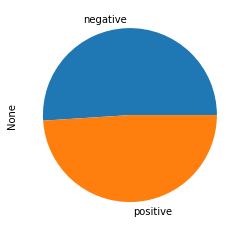

In [208]:
df.groupby(['predicted_sentiment']).size().plot(kind='pie', y='value_column')

In [210]:
def convert(to_be_converted):
    return str(to_be_converted)[0:10]

In [211]:
new_df['date'] = df.apply(lambda row: convert(row['created_at']), axis =1)

In [212]:
new_df.head(5)

,index,created_at,id,text,lang,text_cleaned,predicted_sentiment,date
0,0,2022-02-04T06:59:55.000Z,1489493905406296064,"RT @DINESHK98891550: In the whole world, 100% ...",en,rt whole world 100 cure diseas like cancer aid...,positive,2022-02-04
1,0,2022-02-04T06:59:55.000Z,1489493905426956288,RT @nicksey: Lol we're in trouble when he star...,en,rt lol troubl start tweet indonesian loud cri ...,negative,2022-02-04
2,0,2022-02-04T06:59:55.000Z,1489493905410121733,Vaccine manufacturers cannot be sued … what an...,en,vaccin manufactur cannot sue idiot,negative,2022-02-04
3,0,2022-02-04T06:59:55.000Z,1489493905619832834,"We just gave China 1.2 Billion, yes Billion, f...",en,give china 1 2 billion yes billion covid test ...,negative,2022-02-04
4,0,2022-02-04T06:59:55.000Z,1489493905951186947,RT @nicksey: Lol we're in trouble when he star...,en,rt lol troubl start tweet indonesian loud cri ...,negative,2022-02-04


In [213]:
new_df.groupby(['date','predicted_sentiment']).size()

date        predicted_sentiment
2022-02-04  negative               20380
            positive               17813
2022-02-11  negative               31538
            positive               30853
2022-02-18  negative               24112
            positive               23671
2022-02-25  negative               13083
            positive               13210
dtype: int64

In [219]:
positives = []
negatives = []
counts_sentiments = new_df.groupby(['date','predicted_sentiment'])['date'].count().tolist()
for i in range(len(counts_sentiments)):
    if i % 2 != 0:
        positives.append(counts_sentiments[i])
    else:
        negatives.append(counts_sentiments[i])

print(positives)
print(negatives)

[17813, 30853, 23671, 13210]
[20380, 31538, 24112, 13083]


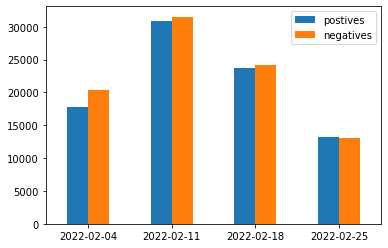

In [220]:
# Plot the setiments on Fridays of Feburary 2022
index = ['2022-02-04', '2022-02-11', '2022-02-18', '2022-02-25']
df = pd.DataFrame({'postives': positives,
                   'negatives': negatives}, index=index)

ax = df.plot.bar(rot=0)